<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/Waiter_Calling_solution_tousif_bin_parves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Get Video
!wget -q -P video/ https://ml-hiring.fringecore.sh/waiter_calling/desk_video.mp4
!wget -q -P video/ https://ml-hiring.fringecore.sh/waiter_calling/IMG.png
print("✅ Downloaded video/desk_video.mp4 and video/IMG.png")

✅ Downloaded video/desk_video.mp4 and video/IMG.png


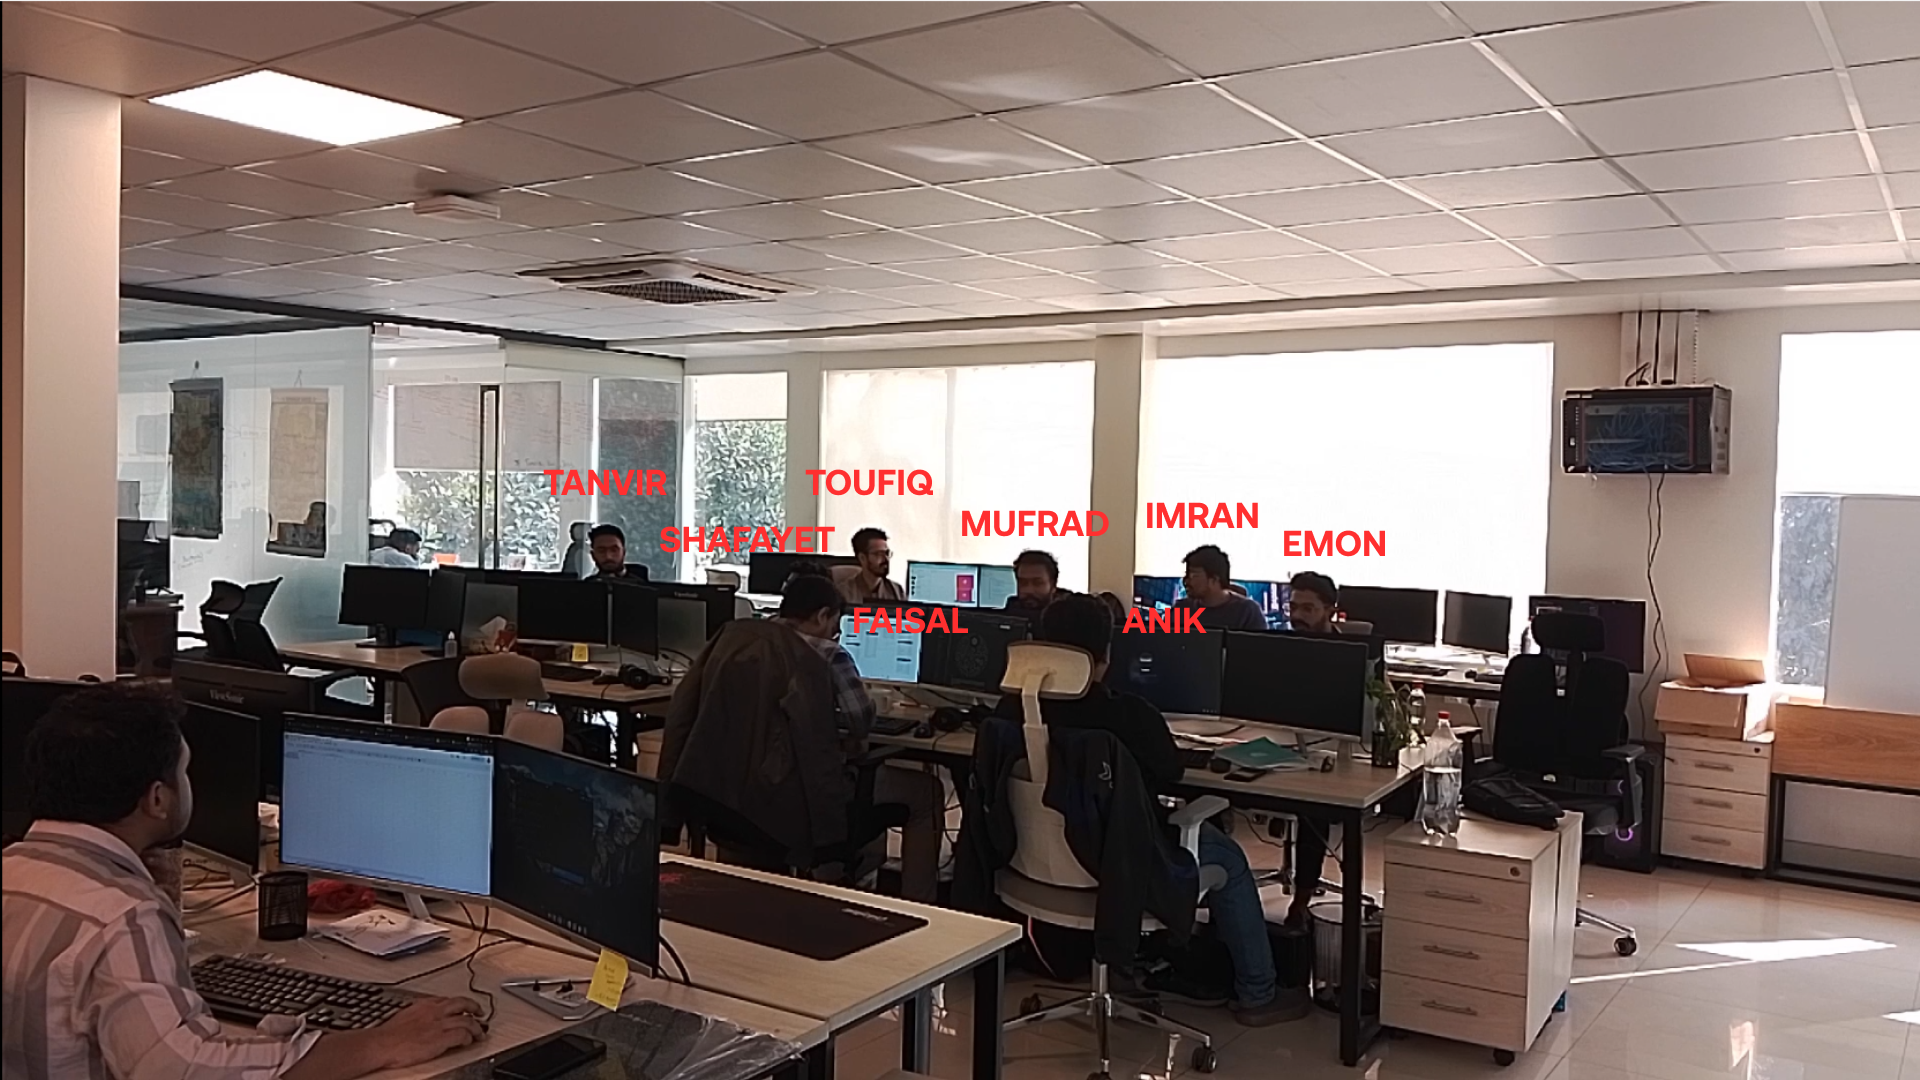

In [2]:
# @title Display Video & Desk Layout
from IPython.display import HTML, Image, display
from base64 import b64encode

# Display the video
mp4 = open("video/desk_video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""
<video width=640 controls>
  <source src="{data_url}" type="video/mp4">
</video>
"""))

# Display the seating chart
display(Image(filename="video/IMG.png"))

In [3]:
# @title Function to Implement 1 — Detect Raised Hands (Pose-based)
import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

def detect_raised_hands(video_path):
    """
    Scan video; return list of (frame_idx, x_px, y_px)
    when either wrist is above its shoulder.
    """
    cap = cv2.VideoCapture(video_path)
    events = []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = pose.process(rgb)
        if res.pose_landmarks:
            lm = res.pose_landmarks.landmark
            # left
            if lm[mp_pose.PoseLandmark.LEFT_WRIST].y < lm[mp_pose.PoseLandmark.LEFT_SHOULDER].y:
                x = int(lm[mp_pose.PoseLandmark.LEFT_WRIST].x * w)
                y = int(lm[mp_pose.PoseLandmark.LEFT_WRIST].y * h)
                events.append((idx, x, y))
            # right
            if lm[mp_pose.PoseLandmark.RIGHT_WRIST].y < lm[mp_pose.PoseLandmark.RIGHT_SHOULDER].y:
                x = int(lm[mp_pose.PoseLandmark.RIGHT_WRIST].x * w)
                y = int(lm[mp_pose.PoseLandmark.RIGHT_WRIST].y * h)
                events.append((idx, x, y))
        idx += 1
    cap.release()
    return events

In [4]:
# @title Function to Implement 2 — Dynamic Map to Desks
import numpy as np
from sklearn.cluster import KMeans

def map_raised_to_desks(raised_events, frame_shape):
    """
    Cluster raised_events into seats dynamically.
    Top row: 5 desks A–E (Tanvir, Shafayet Toufiq, Mufrad, Imran, Emon)
    Front row: 2 desks F–G (Faisal, Anik)
    """
    h, w = frame_shape
    top = [(f, x, y) for f,x,y in raised_events if y <  h/2]
    bot = [(f, x, y) for f,x,y in raised_events if y >= h/2]

    top_names = ["TANVIR","SHAFAYET_TOUFIQ","MUFRAD","IMRAN","EMON"]
    bot_names = ["FAISAL","ANIK"]

    def _cluster(events, names):
        if not events:
            return []
        X = np.array([[x] for (_,x,_) in events])
        km = KMeans(n_clusters=len(names), random_state=0).fit(X)
        centers = km.cluster_centers_.flatten()
        # sort centers left→right then assign names in that order
        sorted_pairs = sorted(zip(centers, names))
        order = [name for _,name in sorted_pairs]
        mapped = []
        for (evt, lbl) in zip(events, km.labels_):
            mapped.append((evt[0], order[lbl]))
        return mapped

    return _cluster(top, top_names) + _cluster(bot, bot_names)

In [6]:
# @title Define stitch_raised_frames
import cv2
from matplotlib import pyplot as plt

def stitch_raised_frames(video_path, frame_indices, output_path="/content/stitched.jpg"):
    """
    Extracts the frames at the given indices, stitches them horizontally,
    saves to output_path, and returns that path.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    for idx in sorted(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    cap.release()

    if not frames:
        raise RuntimeError("No frames to stitch.")

    # normalize heights
    min_h = min(f.shape[0] for f in frames)
    resized = [cv2.resize(f, (int(f.shape[1] * min_h / f.shape[0]), min_h))
               for f in frames]

    pano = cv2.hconcat(resized)
    cv2.imwrite(output_path, pano)

    # display inline
    plt.figure(figsize=(12, 4))
    plt.imshow(cv2.cvtColor(pano, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return output_path

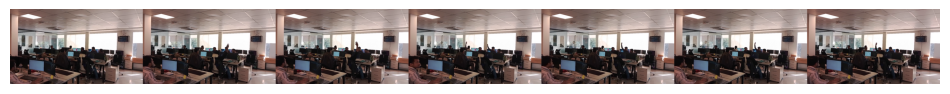

Stitched image saved at: /content/stitched.jpg


In [7]:
# @title Final Eval — Stitch Representative Frames
# (re-run this after defining stitch_raised_frames)
stitched = stitch_raised_frames(video_path, list(unique.values()))
print("Stitched image saved at:", stitched)